# AnimalCLEF 2025 Data Exploration

**Author:** Charlie Clark \
**Date:** March 9, 2025

In [1]:
from sklearn.decomposition import PCA
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from torchvision.io import read_image
from torchvision.transforms import Resize

from torch.utils.data import Dataset, DataLoader
import torch

## Embedding

Uses DINO to embed all database and query images for later visualization.

In [2]:
BASE_PATH = '/storage/scratch1/0/cclark339/animal-clef-2025/'
METADATA_PATH = BASE_PATH + 'metadata.csv'

In [3]:
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


In [4]:
metadata_df['species'].unique()

array(['lynx', nan, 'salamander', 'loggerhead turtle'], dtype=object)

In [5]:
class AnimalClef2025Dataset(Dataset):
    def __init__(self, metadata_df: pd.DataFrame, base_path: str, transforms=None):
        '''
        Initialize AnimalClef2025Dataset instance.
        
        Inputs:
            metadata_df: a pandas DataFrame object containing the provided metadata.
            base_path: a string representing the path to the root of the Animal CLEF 2025 data directory.
            transforms: a list of PyTorch image transforms.
        '''
        
        self.metadata_df = metadata_df
        self.base_path = base_path
        self.transforms = transforms
        
    def __len__(self):
        '''
        Returns the number of images in the dataset.
        '''
        
        return self.metadata_df.shape[0]
    
    def __getitem__(self, idx: int):
        '''
        Gets the set of relevant information from the dataset given the input index.
        
        Inputs:
            idx: the index from which the information should be returned from the dataset.
            
        Returns:
            img: the (transformed) image stored at the path in the input index.
            identity: the identity label associated with the returned image.
            species: the species label associated with the returned image.
        '''
        
        img_path = os.path.join(self.base_path, self.metadata_df['path'].iloc[idx])
        img = read_image(img_path)
        
        identity = f'{self.metadata_df["species"].iloc[idx]}_query' if (self.metadata_df['split'].iloc[idx] == 'query') else self.metadata_df['identity'].iloc[idx]
        species = 'unknown' if self.metadata_df['species'].iloc[idx] not in ['lynx', 'salamander', 'loggerhead turtle'] else self.metadata_df['species'].iloc[idx]
        
        if self.transforms:
            img = self.transforms(img).float()
            
        return img, identity, species

In [6]:
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
model.eval()

Using cache found in /storage/home/hcoda1/0/cclark339/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [7]:
dataset = AnimalClef2025Dataset(metadata_df, base_path=BASE_PATH, transforms=Resize((256, 256)))

In [8]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [9]:
data = []

with torch.no_grad():
    for batch, (X, y_ids, y_specs) in tqdm(enumerate(dataloader), total=len(dataloader)):
        embeddings = model(X)
        
        for i in range(len(y_ids)):
            embedding = embeddings[i]
            y_id = y_ids[i]
            y_spec = y_specs[i]
            
            data.append([y_id, y_spec] + embedding.tolist())
            
columns = ['identity', 'species'] + [f'embedding_dim{dim + 1}' for dim in range(384)]

embeddings_df = pd.DataFrame.from_records(data, columns=columns)

  0%|          | 0/951 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 951/951 [10:00<00:00,  1.58it/s]


In [10]:
embeddings_df

,identity,species,embedding_dim1,embedding_dim2,embedding_dim3,embedding_dim4,embedding_dim5,embedding_dim6,embedding_dim7,embedding_dim8,...,embedding_dim375,embedding_dim376,embedding_dim377,embedding_dim378,embedding_dim379,embedding_dim380,embedding_dim381,embedding_dim382,embedding_dim383,embedding_dim384
0,lynx_query,lynx,-0.132259,-1.235283,-4.838496,3.737148,0.733552,1.820568,-5.781630,2.252462,...,-2.154084,3.722116,-1.017898,-3.577515,-0.186942,8.306604,-0.485099,-0.563090,10.365823,-0.712884
1,SeaTurtleID2022_t591,loggerhead turtle,-0.950087,-4.554310,-1.128851,-0.868525,1.275994,6.424516,-5.315212,-0.813413,...,2.934869,1.672325,0.033137,0.213680,2.213981,6.981472,4.271991,-4.108202,-3.172571,4.970416
2,salamander_query,salamander,-2.467706,-1.641368,0.550839,0.307706,-0.865483,3.898934,-4.309134,-3.292456,...,4.122241,3.113480,-3.057154,-3.653411,-1.223652,0.192362,3.100893,-2.176097,-6.195023,8.582778
3,LynxID2025_lynx_25,lynx,1.260382,0.383420,-3.321836,1.395988,-0.971403,-1.279406,-6.920454,-2.536864,...,4.519553,4.717168,-1.404718,-4.347254,-1.760557,0.998455,2.227197,-0.542530,3.410078,6.244016
4,LynxID2025_lynx_63,lynx,2.737159,-1.190796,-4.059665,1.363766,-0.023755,-2.834048,-4.031539,-1.920725,...,3.804933,5.647914,-1.531913,-3.489684,-2.953381,2.453106,-0.613112,0.015067,3.308634,5.760993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15204,loggerhead turtle_query,loggerhead turtle,-1.119275,-4.451674,-1.405015,0.463242,0.661598,5.496512,-6.194724,-1.498987,...,2.980573,1.955237,-1.051776,-0.835662,1.876495,7.443228,4.037507,-3.699133,-1.940455,3.569164
15205,SeaTurtleID2022_t033,loggerhead turtle,-0.987044,-1.335668,-0.563946,3.867516,-0.842112,3.148140,-6.479171,-2.598554,...,1.794731,1.665556,-4.050614,-3.795959,-1.576460,5.782402,2.067104,-5.091179,4.357144,1.014809
15206,SeaTurtleID2022_t085,loggerhead turtle,-0.948721,-2.436939,-1.485103,2.984632,0.277827,3.813905,-6.959260,-2.182163,...,2.023731,1.636362,-2.937280,-2.945438,0.338244,7.323483,2.833037,-4.741863,2.309221,0.893364
15207,LynxID2025_lynx_32,lynx,-0.687192,0.696913,-3.300632,4.198469,0.559433,1.976453,-7.910548,-1.858576,...,3.764852,4.114396,-3.224708,-3.753543,-0.421928,4.389744,0.571593,0.108864,5.312013,3.061348


## Visualizations

Includes frequency bar plots and PCA scatter plots.

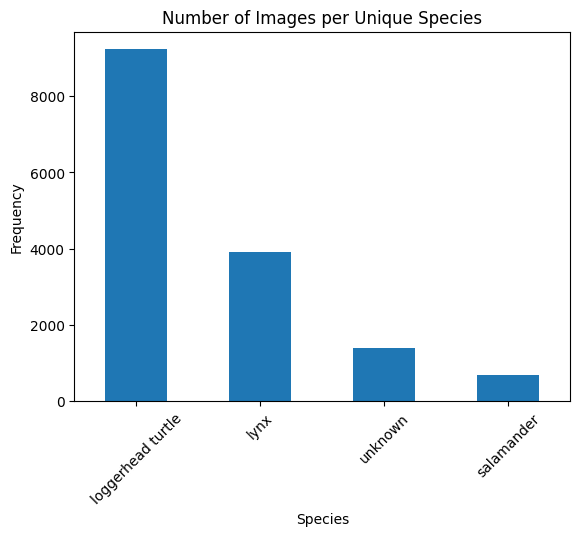

In [11]:
embeddings_df['species'].value_counts().plot(kind='bar')
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.title('Number of Images per Unique Species')
plt.xticks(rotation=45)
plt.show()

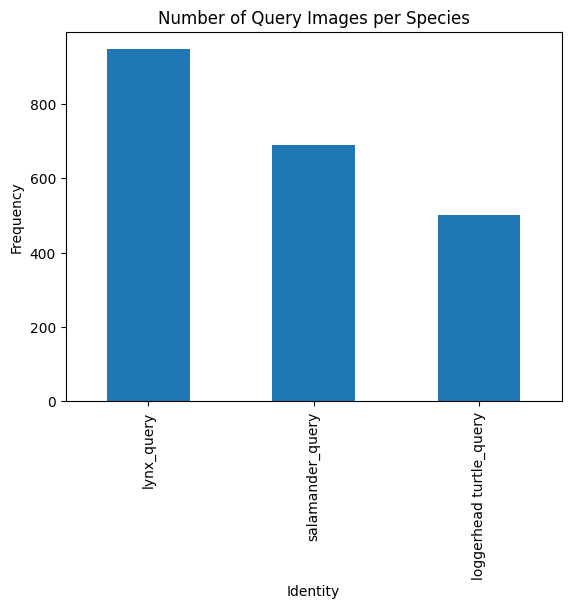

In [12]:
embeddings_df['identity'].value_counts()[:3].plot(kind='bar')
plt.xlabel('Identity')
plt.ylabel('Frequency')
plt.title('Number of Query Images per Species')
plt.show()

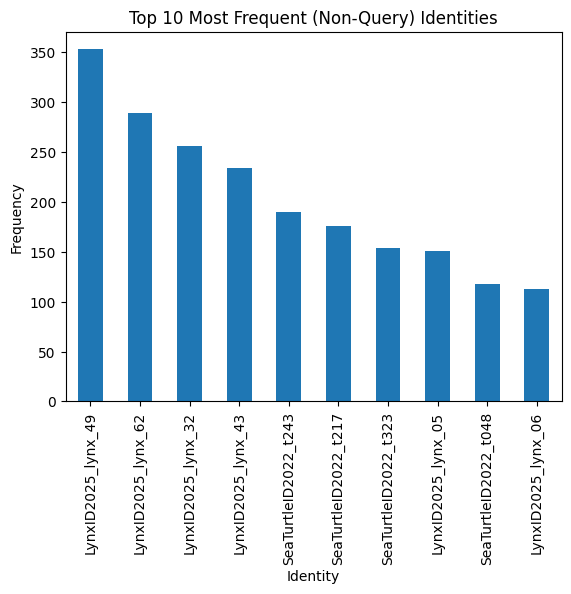

In [13]:
embeddings_df['identity'].value_counts()[3:13].plot(kind='bar')
plt.xlabel('Identity')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent (Non-Query) Identities')
plt.show()

In [14]:
embeddings = embeddings_df.iloc[:, 2:]
labels = embeddings_df.iloc[:, :2]

In [15]:
embeddings

,embedding_dim1,embedding_dim2,embedding_dim3,embedding_dim4,embedding_dim5,embedding_dim6,embedding_dim7,embedding_dim8,embedding_dim9,embedding_dim10,...,embedding_dim375,embedding_dim376,embedding_dim377,embedding_dim378,embedding_dim379,embedding_dim380,embedding_dim381,embedding_dim382,embedding_dim383,embedding_dim384
0,-0.132259,-1.235283,-4.838496,3.737148,0.733552,1.820568,-5.781630,2.252462,-8.196237,-0.310133,...,-2.154084,3.722116,-1.017898,-3.577515,-0.186942,8.306604,-0.485099,-0.563090,10.365823,-0.712884
1,-0.950087,-4.554310,-1.128851,-0.868525,1.275994,6.424516,-5.315212,-0.813413,-0.925189,-7.004402,...,2.934869,1.672325,0.033137,0.213680,2.213981,6.981472,4.271991,-4.108202,-3.172571,4.970416
2,-2.467706,-1.641368,0.550839,0.307706,-0.865483,3.898934,-4.309134,-3.292456,0.587959,-0.599625,...,4.122241,3.113480,-3.057154,-3.653411,-1.223652,0.192362,3.100893,-2.176097,-6.195023,8.582778
3,1.260382,0.383420,-3.321836,1.395988,-0.971403,-1.279406,-6.920454,-2.536864,-3.078682,3.235050,...,4.519553,4.717168,-1.404718,-4.347254,-1.760557,0.998455,2.227197,-0.542530,3.410078,6.244016
4,2.737159,-1.190796,-4.059665,1.363766,-0.023755,-2.834048,-4.031539,-1.920725,-3.074231,4.861078,...,3.804933,5.647914,-1.531913,-3.489684,-2.953381,2.453106,-0.613112,0.015067,3.308634,5.760993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15204,-1.119275,-4.451674,-1.405015,0.463242,0.661598,5.496512,-6.194724,-1.498987,-2.317300,-6.014497,...,2.980573,1.955237,-1.051776,-0.835662,1.876495,7.443228,4.037507,-3.699133,-1.940455,3.569164
15205,-0.987044,-1.335668,-0.563946,3.867516,-0.842112,3.148140,-6.479171,-2.598554,-3.373263,-0.700170,...,1.794731,1.665556,-4.050614,-3.795959,-1.576460,5.782402,2.067104,-5.091179,4.357144,1.014809
15206,-0.948721,-2.436939,-1.485103,2.984632,0.277827,3.813905,-6.959260,-2.182163,-3.800958,-2.308166,...,2.023731,1.636362,-2.937280,-2.945438,0.338244,7.323483,2.833037,-4.741863,2.309221,0.893364
15207,-0.687192,0.696913,-3.300632,4.198469,0.559433,1.976453,-7.910548,-1.858576,-4.596908,1.972834,...,3.764852,4.114396,-3.224708,-3.753543,-0.421928,4.389744,0.571593,0.108864,5.312013,3.061348


In [16]:
labels

,identity,species
0,lynx_query,lynx
1,SeaTurtleID2022_t591,loggerhead turtle
2,salamander_query,salamander
3,LynxID2025_lynx_25,lynx
4,LynxID2025_lynx_63,lynx
...,...,...
15204,loggerhead turtle_query,loggerhead turtle
15205,SeaTurtleID2022_t033,loggerhead turtle
15206,SeaTurtleID2022_t085,loggerhead turtle
15207,LynxID2025_lynx_32,lynx


In [17]:
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(embeddings)

columns = ['Component_1', 'Component_2']
pca_df = pd.DataFrame.from_records(pca_embeddings, columns=columns)
pca_df[['Identity', 'Species']] = labels

pca_df

,Component_1,Component_2,Identity,Species
0,18.071638,59.468201,lynx_query,lynx
1,62.604349,5.654562,SeaTurtleID2022_t591,loggerhead turtle
2,-7.860943,-32.733653,salamander_query,salamander
3,-49.017630,6.990462,LynxID2025_lynx_25,lynx
4,-56.207205,14.335641,LynxID2025_lynx_63,lynx
...,...,...,...,...
15204,55.374006,1.431320,loggerhead turtle_query,loggerhead turtle
15205,13.011290,-10.415265,SeaTurtleID2022_t033,loggerhead turtle
15206,29.519431,-5.520317,SeaTurtleID2022_t085,loggerhead turtle
15207,-10.037810,30.234557,LynxID2025_lynx_32,lynx


[Text(1, 0, 'lynx'),
 Text(1, 1, 'loggerhead turtle'),
 Text(1, 2, 'salamander'),
 Text(1, 3, 'unknown')]

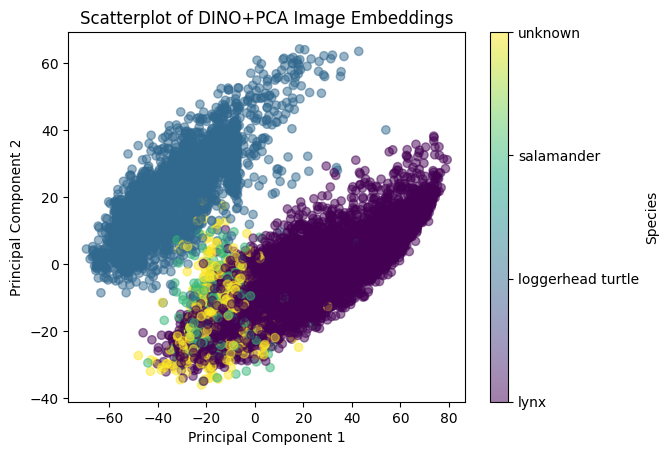

In [18]:
plt.scatter(pca_df['Component_1'], pca_df['Component_2'], c=pca_df['Species'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of DINO+PCA Image Embeddings')
cbar = plt.colorbar(label='Species', ticks=range(4))
cbar.ax.set_yticklabels(pca_df['Species'].unique())

In [19]:
turts_df = pca_df[pca_df['Species'] == 'loggerhead turtle']
turts_df

,Component_1,Component_2,Identity,Species
1,62.604349,5.654562,SeaTurtleID2022_t591,loggerhead turtle
5,22.079995,-17.502762,SeaTurtleID2022_t338,loggerhead turtle
7,23.971464,1.615064,SeaTurtleID2022_t424,loggerhead turtle
8,32.419624,-3.069502,SeaTurtleID2022_t471,loggerhead turtle
10,36.686942,6.016606,SeaTurtleID2022_t328,loggerhead turtle
...,...,...,...,...
15201,-17.707009,-25.126230,SeaTurtleID2022_t033,loggerhead turtle
15202,-21.419286,-26.182582,SeaTurtleID2022_t023,loggerhead turtle
15204,55.374006,1.431320,loggerhead turtle_query,loggerhead turtle
15205,13.011290,-10.415265,SeaTurtleID2022_t033,loggerhead turtle


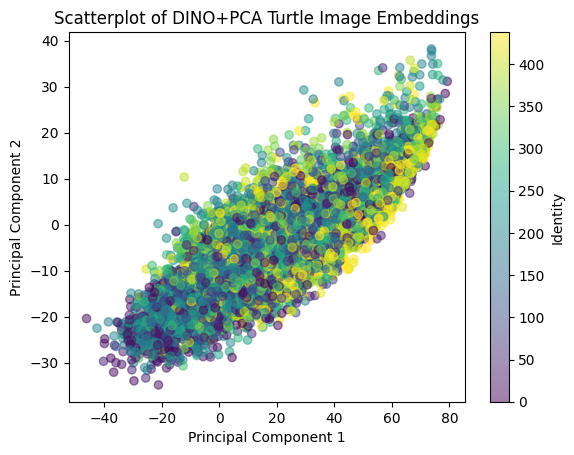

In [20]:
plt.scatter(turts_df['Component_1'], turts_df['Component_2'], c=turts_df['Identity'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of DINO+PCA Turtle Image Embeddings')
plt.colorbar(label='Identity')

In [21]:
sals_df = pca_df[(pca_df['Species'] == 'salamander') | (pca_df['Species'] == 'unknown')]
sals_df

,Component_1,Component_2,Identity,Species
2,-7.860943,-32.733653,salamander_query,salamander
24,-19.803576,-13.018339,salamander_query,salamander
42,-18.337454,-17.315768,SalamanderID2025_143,unknown
44,-16.422073,19.500286,SalamanderID2025_308,unknown
48,10.147519,-22.552493,SalamanderID2025_342,unknown
...,...,...,...,...
15137,-15.405802,-12.033099,SalamanderID2025_134,unknown
15139,-4.295175,-17.350053,salamander_query,salamander
15145,-21.426860,-23.401761,salamander_query,salamander
15151,-5.891599,-4.175535,SalamanderID2025_167,unknown


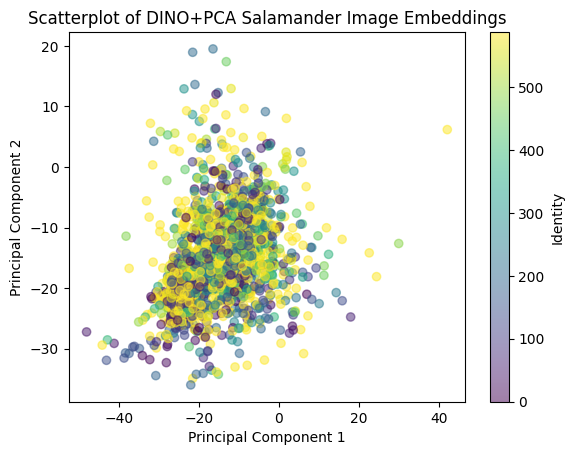

In [22]:
plt.scatter(sals_df['Component_1'], sals_df['Component_2'], c=sals_df['Identity'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of DINO+PCA Salamander Image Embeddings')
plt.colorbar(label='Identity')

In [23]:
lynx_df = pca_df[pca_df['Species'] == 'lynx']
lynx_df

,Component_1,Component_2,Identity,Species
0,18.071638,59.468201,lynx_query,lynx
3,-49.017630,6.990462,LynxID2025_lynx_25,lynx
4,-56.207205,14.335641,LynxID2025_lynx_63,lynx
6,-28.302118,23.014146,LynxID2025_lynx_62,lynx
9,-33.279889,7.765746,lynx_query,lynx
...,...,...,...,...
15197,-12.966528,27.354820,lynx_query,lynx
15199,-8.405657,29.519194,LynxID2025_lynx_05,lynx
15203,-9.446589,31.522638,LynxID2025_lynx_49,lynx
15207,-10.037810,30.234557,LynxID2025_lynx_32,lynx


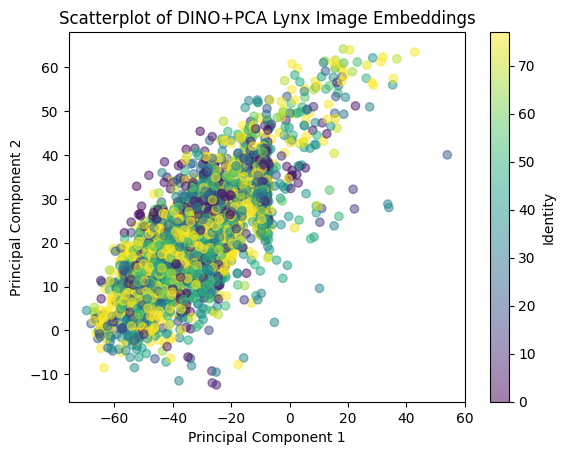

In [24]:
plt.scatter(lynx_df['Component_1'], lynx_df['Component_2'], c=lynx_df['Identity'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of DINO+PCA Lynx Image Embeddings')
plt.colorbar(label='Identity')